In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

import torch
import torch.nn as nn
torch.manual_seed(1234)
torch.cuda.manual_seed(1234)
device = torch.device('cuda:0')

# Reading Data

In [2]:
df = pd.read_csv('../Data/airline_passengers.csv',index_col='Month',parse_dates=True)
df.index.freq = 'MS'
df.head()

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Freq: MS
Data columns (total 1 columns):
Thousands of Passengers    144 non-null int64
dtypes: int64(1)
memory usage: 2.2 KB


# Preprocessing

In [4]:
# storing mean and variance
series_mean = df['Thousands of Passengers'].mean()
series_std = df['Thousands of Passengers'].std()

In [5]:
# Normalizing
df['Yt_true'] = df['Thousands of Passengers']
df['Yt_true'] = (df['Yt_true'] - series_mean) / series_std

In [6]:
lag = 5
for i in range(lag, 0, -1):
    df['Yt-' + str(i)] = df['Yt_true'].shift(i)

In [7]:
df.head()

,Thousands of Passengers,Yt_true,Yt-5,Yt-4,Yt-3,Yt-2,Yt-1
Month,,,,,,,
1949-01-01,112,-1.402882,NaN,NaN,NaN,NaN,NaN
1949-02-01,118,-1.352868,NaN,NaN,NaN,NaN,-1.402882
1949-03-01,132,-1.236169,NaN,NaN,NaN,-1.402882,-1.352868
1949-04-01,129,-1.261176,NaN,NaN,-1.402882,-1.352868,-1.236169
1949-05-01,121,-1.327861,NaN,-1.402882,-1.352868,-1.236169,-1.261176


In [8]:
df.dropna(inplace=True)

In [9]:
df.head()

,Thousands of Passengers,Yt_true,Yt-5,Yt-4,Yt-3,Yt-2,Yt-1
Month,,,,,,,
1949-06-01,135,-1.211162,-1.402882,-1.352868,-1.236169,-1.261176,-1.327861
1949-07-01,148,-1.102798,-1.352868,-1.236169,-1.261176,-1.327861,-1.211162
1949-08-01,148,-1.102798,-1.236169,-1.261176,-1.327861,-1.211162,-1.102798
1949-09-01,136,-1.202826,-1.261176,-1.327861,-1.211162,-1.102798,-1.102798
1949-10-01,119,-1.344532,-1.327861,-1.211162,-1.102798,-1.102798,-1.202826


In [10]:
len(df)

139

In [11]:
arr = df.values

In [12]:
npx = arr[:, 2:]
npy = arr[:, 1]

In [13]:
X = torch.from_numpy(npx).unsqueeze(2).float()
Y = torch.from_numpy(npy).float()
X = X.to(device)
Y = Y.to(device)

In [14]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, x, trace=False):
        if trace:
            print(x.shape, self.hidden_cell[0].shape)
        lstm_out, self.hidden_cell = self.lstm(x, self.hidden_cell)
        if trace:
            print(lstm_out.shape, self.hidden_cell[0].shape, self.hidden_cell[1].shape)
        predictions = self.linear(lstm_out)
        if trace:
            print(predictions.shape)
        predictions = predictions.squeeze()
        return predictions[:, -1]
    
    def predict(self, x):
        self.hidden_cell = (torch.zeros(1, x.shape[0], model.hidden_layer_size).to(device),
                        torch.zeros(1, x.shape[0], model.hidden_layer_size).to(device))
        return self.forward(x)

In [15]:
model = LSTMModel()
model = model.to(device)

In [16]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

In [17]:
trainX = X[:120]
trainY_true = Y[:120]
testX = X[120:]
testY_true = Y[120:]

In [18]:
BS = 32
for i in range(1000):
    optimizer.zero_grad()
    y_pred = model.predict(trainX)
    
    loss = criterion(y_pred, trainY_true)
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        print(i, loss.item())

0 0.7012959718704224
100 0.5305541753768921
200 0.2648106813430786
300 0.1480572521686554
400 0.14377924799919128
500 0.1392177939414978
600 0.13390286266803741
700 0.1274072527885437
800 0.11905030161142349
900 0.10824801027774811


In [19]:
trainY_pred = model.predict(trainX)

In [20]:
rescaled_trainY_true = (trainY_true * series_std) + series_mean
rescaled_trainY_pred = (trainY_pred * series_std) + series_mean

In [21]:
testY_pred = model.predict(testX)

In [22]:
Y_pred = torch.cat([trainY_pred, testY_pred], dim=0)

In [23]:
len(Y_pred)

139

In [24]:
df['Yt_pred'] = Y_pred.cpu().detach().numpy()

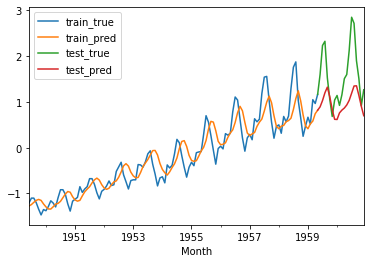

In [25]:
df['Yt_true'][:120].plot(legend=True, label='train_true')
df['Yt_pred'][:120].plot(legend=True, label='train_pred')
df['Yt_true'][119:].plot(legend=True, label='test_true')
df['Yt_pred'][119:].plot(legend=True, label='test_pred')

In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(df['Yt_true'], df['Yt_pred'])
print('MSE : %f' % mse)
rmse = np.sqrt(mse)
print('RMSE: %f' % rmse)
nrmse_mean = rmse/np.mean(df['Yt_true'])
print('NRMSE using mean: %f' % nrmse_mean)
nrmse_std = rmse/np.std(df['Yt_true'])
print('NRMSE using stdev: %f' % nrmse_std)
nrmse_range = rmse/(np.max(df['Yt_true'])- np.min(df['Yt_true']))
print('NRMSE using range: %f' % nrmse_range)
mae = mean_absolute_error(df['Yt_true'], df['Yt_pred'])
print('MAE: %f' % mae)

MSE : 0.164338
RMSE: 0.405386
NRMSE using mean: 8.562379
NRMSE using stdev: 0.412867
NRMSE using range: 0.093885
MAE: 0.286262


In [27]:
print('Train')
mse = mean_squared_error(df['Yt_true'][:120], df['Yt_pred'][:120])
print('MSE : %f' % mse)
rmse = np.sqrt(mse)
print('RMSE: %f' % rmse)
nrmse_mean = rmse/np.mean(df['Yt_true'][:120])
print('NRMSE using mean: %f' % nrmse_mean)
nrmse_std = rmse/np.std(df['Yt_true'][:120])
print('NRMSE using stdev: %f' % nrmse_std)
nrmse_range = rmse/(np.max(df['Yt_true'][:120])- np.min(df['Yt_true'][:120]))
print('NRMSE using range: %f' % nrmse_range)

print('\n\nTest')
mse = mean_squared_error(df['Yt_true'][120:], df['Yt_pred'][120:])
print('MSE : %f' % mse)
rmse = np.sqrt(mse)
print('RMSE: %f' % rmse)
nrmse_mean = rmse/np.mean(df['Yt_true'][120:])
print('NRMSE using mean: %f' % nrmse_mean)
nrmse_std = rmse/np.std(df['Yt_true'][120:])
print('NRMSE using stdev: %f' % nrmse_std)
nrmse_range = rmse/(np.max(df['Yt_true'][120:])- np.min(df['Yt_true'][120:]))
print('NRMSE using range: %f' % nrmse_range)

Train
MSE : 0.096184
RMSE: 0.310136
NRMSE using mean: -1.586134
NRMSE using stdev: 0.391731
NRMSE using range: 0.092783


Test
MSE : 0.594780
RMSE: 0.771220
NRMSE using mean: 0.487716
NRMSE using stdev: 1.269945
NRMSE using range: 0.355848
